# Parte II - Extracción de las series de tiempo a través de Yahoo Finance y arquitectura LSTM

### Carga de los datos y tratamiento

In [1]:
import torch
import pandas as pd

torch.__version__

'2.3.1+cu121'

In [2]:
torch.manual_seed(77)

In [3]:
import yfinance as yf

data = yf.download('TSLA', start='2019-01-01', end='2024-11-01', interval='1d')

data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2019-01-02 00:00:00+00:00,20.674667,20.674667,21.008667,19.920000,20.406668,174879000
2019-01-03 00:00:00+00:00,20.024000,20.024000,20.626667,19.825333,20.466667,104478000
2019-01-04 00:00:00+00:00,21.179333,21.179333,21.200001,20.181999,20.400000,110911500
2019-01-07 00:00:00+00:00,22.330667,22.330667,22.449333,21.183332,21.448000,113268000
2019-01-08 00:00:00+00:00,22.356667,22.356667,22.934000,21.801332,22.797333,105127500


In [4]:
data.shape

(1469, 6)

### Visualización de los datos

<Axes: title={'center': 'Adj Price TESLA'}, xlabel='Time', ylabel='Price'>

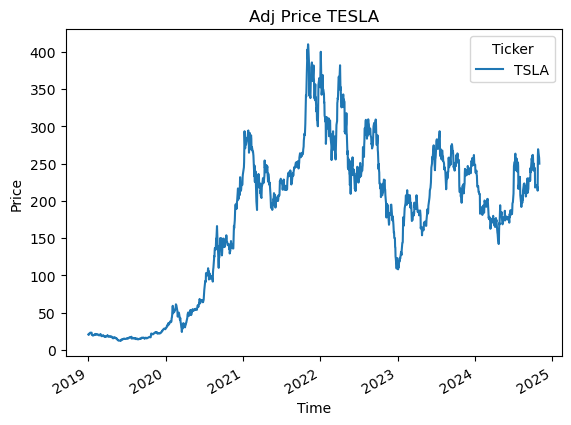

In [5]:
import matplotlib.pyplot as plt

data_adj = data['Adj Close'].dropna()

data_adj.plot(title='Adj Price TESLA', xlabel='Time', ylabel = 'Price')

- Para obtener mejores resultados debemos deshacernos de la estacionalidad,  del ruido y normalizar nuestras series de tiempo. Primero evaluamos tres maneras de eliminar la estacionalidad a partir del primedio de los residuales. Entre más alejado sea de 0, será el método que más nos convenga.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

des_add = seasonal_decompose(data_adj, model='additive', period=365)
des_mult = seasonal_decompose(data_adj, model='multiplicative', period=365)
des_stl = STL(data_adj, period = 365).fit()

In [7]:
des_add.resid.mean(), des_mult.resid.mean(), des_stl.resid.mean()

(2.3010124391920863, 0.9670052173817174, 1.5954741079891235)

- Una vez analizados los promedios residuales nos percatamos que el promedio más bajo es el de la descomposición multiplicativa, por lo que elegiremos este

In [8]:
estacionalidad = des_mult.seasonal

In [9]:
data_clean = data_adj['TSLA'] - estacionalidad

<Axes: xlabel='Date'>

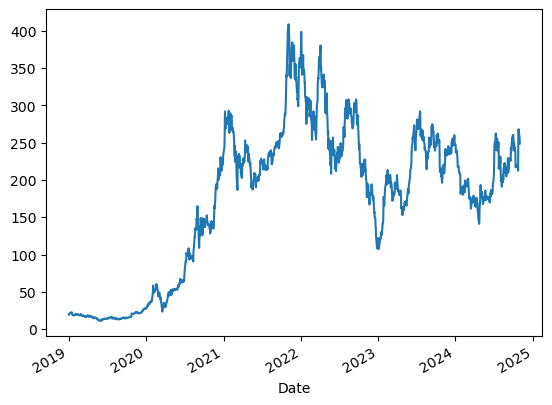

In [10]:
data_clean.plot()

- División entre datos de entrenamiento y datos de evaluación

In [11]:
train_size = int(len(data_clean) * 0.67)
test_size = len(data_clean) - train_size

train_data, test_data = data_clean[:train_size], data_clean[train_size:]

In [12]:
len(train_data), len(test_data)

(984, 485)

### Pipeline

- Ventanas de predicción para pedirle al modelo que prediga el siguiente dato.

**Window Time**
$$t - w$$

**Window Time Predict**
$$t + 1

In [13]:
def window_time(dataset, lookback):

    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [14]:
lookback = 1
X_train, y_train = window_time(train_data, lookback=lookback)
X_test, y_test = window_time(test_data, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([983, 1]) torch.Size([983, 1])
torch.Size([484, 1]) torch.Size([484, 1])


C:\Users\aleja\AppData\Local\Temp\ipykernel_4832\2988494864.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(X), torch.tensor(y)


### Modelo - Arquitectura LSTM

In [18]:
import torch.nn as nn
from torch import optim
import time
import torch.utils.data as data

In [19]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, 
                        hidden_size=50, 
                        num_layers=1, 
                        batch_first=True)
        self.fc1 = nn.Linear(50, 1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(25, 1)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(25, 1)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

### Entrenamiento

In [20]:
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [ ]:
def train(model, device, data, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for x_serie, y_serie in data:
        x_serie, y_serie = x_serie.to(device), y_serie.to(device)
        y_pred = model(x_serie)
        
